In [35]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

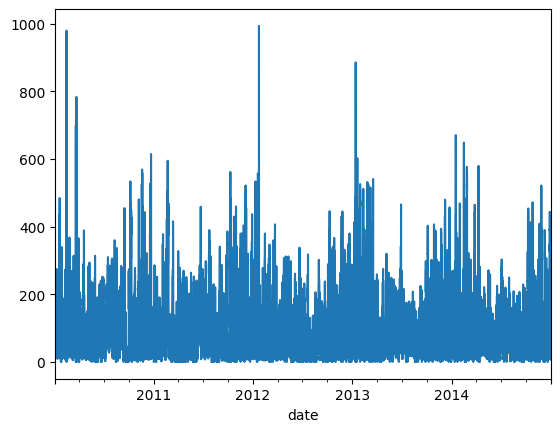

In [36]:
# Загрузка данных
df = pd.read_csv('pollution.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Визуализация данных
df['pollution'].plot()
plt.show()

In [37]:
# Тест Дики-Фуллера на стационарность
result = adfuller(df['pollution'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# Проверка стационарности
if result[1] < 0.05:
    print("Ряд является стационарным")
else:
    print("Ряд не является стационарным")

ADF Statistic: -21.004109
p-value: 0.000000
Ряд является стационарным


C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


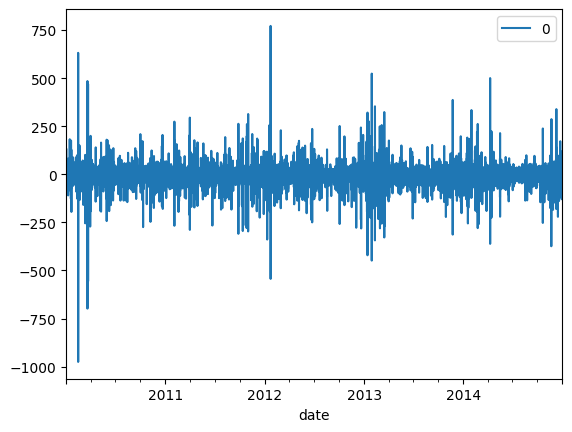

In [38]:
# ARIMA
model = ARIMA(df['pollution'], order=(5,1,0))
model_fit = model.fit()

# Визуализация остатков
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [39]:
# Предсказание
X = df['pollution'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

KeyboardInterrupt: 

In [ ]:
# Визуализация предсказаний
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# Расчет MSE
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

In [ ]:
# LSTM
# Преобразование категориальных данных в числовые
df = pd.get_dummies(df)

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

# Разделение данных на обучающую и тестовую выборки
train, test = train_test_split(scaled, test_size=0.2, random_state=42)

# Преобразование данных для LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Переформатирование входных данных для LSTM [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Обучение модели
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Предсказание
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# Создание scaler для целевой переменной
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target.fit_transform(df[['pollution']])

# Обратное преобразование предсказаний и целевых значений в исходную шкалу
trainPredict = scaler_target.inverse_transform(trainPredict)
trainY = scaler_target.inverse_transform([trainY])
testPredict = scaler_target.inverse_transform(testPredict)
testY = scaler_target.inverse_transform([testY])

In [ ]:
# Расчет MSE
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore))